<h1> Ajuste de modelos a pandemia COVID-19</h1>

El siguiente código descarga datos actuales de la enfermedad los almacena en archivos csv e intenta ajustar los parametros de un modelo SIRD a los datos.

No es el propósito conseguir un gran ajuste, pues es claro que no se lo logrará con un modelo tan básico. El objetivo es construir un código capáz de descargar datos actuales de internet y ajustar un modelo a esos datos. En una etapa posterior se mejorará el modelo utilizado.


In [1]:
import numpy as np
from scipy.integrate import odeint 
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
%matplotlib inline

<h2> Buscando datos de la enfermedad </h2>

Sitio: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [2]:
import requests

In [4]:
################################################################
###  Descarga datos actuales de internet  desde John Hopskins###
####  Cambiar la variable MiDirectorio con el directorio que se desaea trabajar

MiDirectorio='/home/fernando/fer/Investigación/Trabajo en curso/COVID-19/'


urlb='https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2F'
url1 = 'time_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
url2 = 'time_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
url3 = 'time_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'



urlUSA = 'https://covidtracking.com/api/v1/us/daily.csv'

myfile = requests.get(urlUSA)
open(MiDirectorio+'DataUSA.csv', 'wb').write(myfile.content)


myfile = requests.get(urlb+url1)
open(MiDirectorio+'DataConfirmados.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url2)
open(MiDirectorio+'DataMuertos.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url3)
open(MiDirectorio+'DataRecuperados.csv', 'wb').write(myfile.content)

In [3]:
############Para leer datos descargados
import csv

In [4]:

### Los primeros 4 items de la fila son vacio,
### nombre del país, lat, long. No los usamos
### OJO: en los datos de la tabla hay valores acumulados de infectados, en los modelos
### cuentan los  infectados activos 
### Infectados Activos= Infectados Acumulados-(muertos+recuperados)

### S_data,I_data,M_data,R_data=ExtraerDatos(IndPais,Poblacion)
### IndPais = Fila del pais-región
### Poblacion=Total de habitantes
### S_data,I_data,M_data,R_data Datos de Susceptibles, infecciosos, muertes y recuperados


def ExtraerDatos(Pais,Poblacion):
    if Pais=='USA':
        I_data_acum=np.array([])
        I_data=np.array([])
        M_data=np.array([])
        R_data=np.array([])
        S_data=np.array([])

        with open('DataUSA.csv') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)
            for row in reader:
                I_data_acum=np.append(I_data_acum,float(row[2]))
                M_data=np.append(M_data,float('0'+row[14]))
                R_data=np.append(R_data,float('0'+row[11]))
                
            I_data_acum=np.flip(I_data_acum)
            M_data=np.flip(M_data)
            R_data=np.flip(R_data)
    else:
        with open('DataConfirmados.csv') as csvfile:
            reader = csv.reader(csvfile)
            I_data_acum,M_data,R_data=0,0,0
            for row in reader:
                if Pais in row:
                    I_data_acum+=np.array([float(i) for i in row[5:]])
        with open('DataMuertos.csv') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if Pais in row:
                    M_data+=np.array([float(i) for i in row[5:]])
        with open('DataRecuperados.csv') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if Pais in row:
                    R_data+=np.array([float(i) for i in row[5:]])
        i0=min(len(I_data_acum),len(M_data),len(R_data))
        I0=range(i0)
        I_data_acum=I_data_acum[I0]
        R_data=R_data[I0]
        M_data=M_data[I0]


        #Extraemos datos desde el comienzo de la epidemia
    I_data=I_data_acum-(M_data+R_data)
    S_data=Poblacion-I_data_acum #S=Poblacion-Infectados Acumulados
    Ind=I_data_acum>0
    I_data_acum=I_data_acum[Ind]
    I_data=I_data[Ind]
    M_data=M_data[Ind]
    R_data=R_data[Ind]
    S_data=S_data[Ind]
    return S_data,I_data,M_data,R_data,I_data_acum



<h2> Ejemplo. Consultando datos </h2>

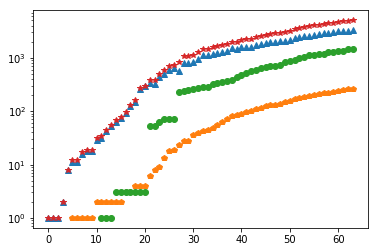

In [5]:
###Ejemplo Argentina
PoblacionArg=44.49e6  #Segun wikipedia
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('Argentina',PoblacionArg)
plt.plot(I_data,'^',M_data,'p',R_data,'o',I_data_acum,'*')
plt.yscale('log')

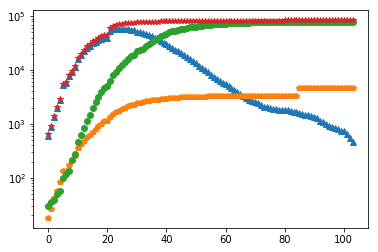

In [6]:
###Ejemplo China
PoblacionChi=1393e6  #Segun wikipedia
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('China',PoblacionChi)
plt.plot(I_data,'^',M_data,'p',R_data,'o',I_data_acum,'*')
plt.yscale('log')

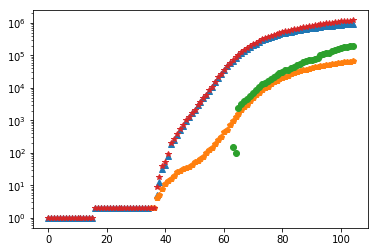

In [7]:
###Ejemplo USA
PoblacionUSA=325719178  #Segun wikipedia
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('USA',PoblacionUSA)
plt.plot(I_data,'^',M_data,'p',R_data,'o',I_data_acum,'*')
plt.yscale('log')

<h2> Modelo SIRD </h2>

<b> Bibliografía </b>

[BCF2019] "Mathematical Models in Epidemiology", Fred Brauer and Carlos Castillo-Chavez and Zhilan Feng, ISBN: 978-14-9399-828-9, Springer Nature,2019.

**Modelo**

SIRD Susceptibles-Infectados-Recuperados y Muertos por la enfermedad
ver sección 2.5 de [BCF2019]

![SIRD](SIRD.png)




$$
\begin{aligned}
&S^{\prime}=-\beta S I\\
&I^{\prime}=\beta S I-(\alpha+d) I\\
&R^{\prime}=\alpha I
\end{aligned}
$$

$$\begin{aligned}
\frac{1}{\alpha}&=\text{periodo infecciosidad medio}\\
\beta&=\text{cantidad de contactos por individuo por unidad de tiempo}\\
d&=\text{tasa de mortalidad}\\
\mathcal{R}_0&=\frac{\beta N}{\alpha+d}=\text{número reproducción básico}\\
            &=\text{Cantidad infecciones a lo largo de la vida de}\\
            &\text{un infeccioso dentro de una población de sólo susceptibles}\\
\end{aligned}
$$


Sólo es necesario modelar las primeras dos ecuaciones

In [8]:
def SIRD(Y,t,alpha,beta,d):
    S,I,R=Y
    dSdt=-beta*S*I
    dIdt=beta*S*I-(alpha+d)*I
    dRdt=alpha*I
    return dSdt,dIdt,dRdt
####### Resolvemos el modelos
def ModeTeor(t,alpha,beta,d,y0):
    sol = odeint(SIRD,y0 ,t, args=(alpha,beta,d))
    return sol

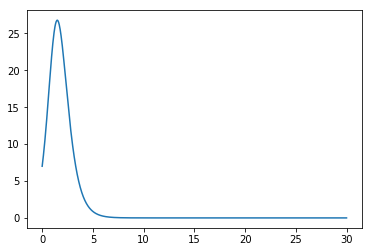

In [13]:
##########Ejemplo################
########## Plaga Eyam, peste bubónica ver seccion 2.4 de [BCF2019]
####alpha=2.73, beta=0.017, d=0
##En realidad hay defiunsiones, se computan con R

Y0=[254,7,0]
t = np.linspace(0,30, 1000)
argus=(2.73, 0.017,0)

sol = odeint(SIRD,Y0 ,t, args=argus)
S,I=sol[:,0],sol[:,1]
plt.plot(t,I)
plt.show()

<h2> Ajuste de los parámetros </h2>

Usaremos el submódulo de optimizacion de la librería SciPy

In [10]:
def error_Mod(x,*params):
    alpha,R0,d=x
    t,S_data,I_data,R_data,M_data,Poblacion=params
    beta=(alpha+d)*R0/Poblacion
    y0=S_data[0],I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeor(t,alpha,beta,d,y0)
    I=Sol[:,1]
    S=Sol[:,0]
    R=Sol[:,2]
    M=Poblacion-S-I-R
    return 100*max(np.abs(I_data-I))/(max(I_data)+1)\
+max(np.abs(S_data-S))/(max(S_data)+1)+max(np.abs(R_data-R))/(max(R_data)+1)\
+max(np.abs(M_data-M))/(max(M_data)+1)

def HallarParametros(t,S_data,I_data,R_data,M_data,Poblacion,rangos):

    ## Usaremos la búsqueda de un mínimo global mediate fuerzar bruta, 
    ## Busqueda en todo el rango

    
    opt=scipy.optimize.brute(error_Mod,rangos,args=(t,S_data,I_data,R_data,M_data,Poblacion),finish=None,full_output=True)
    para_opt,feval=opt[0:2]
    #para_opt= scipy.optimize.basinhopping(error_Mod, (1/30.0,2.0,.02))
    #para_opt= scipy.optimize.minimize(error_Mod,(1/30.0,2.0,.02),method='L-BFGS-B', bounds=rangos)
    return para_opt,feval

def AjusteEpidemia(Pais,Poblacion,*arg):
    S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos(Pais,Poblacion)   
    for ar in arg:
        S_data=S_data[ar]
        I_data=I_data[ar]
        M_data=M_data[ar]
        R_data=R_data[ar]
        I_data_acum=I_data_acum[ar]
    t=np.arange(0,np.shape(I_data)[0],1)
    #rangos = (slice(1/30.0,1/5.0,0.001), slice(1, 4, 0.1), slice(0.001,0.01,.001))
    rangos=(1.0/25.0,1/5.0), (1.0, 8.0), (0.001,0.1)
    para_opt,feval=HallarParametros(t,S_data,I_data,R_data,M_data,Poblacion,rangos)
    alpha,R0,d=para_opt
    beta=R0/Poblacion*(alpha+d)
    y0=S_data[0],I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeor(t, alpha,beta,d,y0)
    I=Sol[:,1]
    S=Sol[:,0]
    R=Sol[:,2]
    M=Poblacion-S-I-R
    #plt.yscale('log')
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
    axes[0,0].plot(t,I ,t,I_data,'o')
    axes[0,0].set_ylabel('I')
    axes[0,0].set_yscale('log')
    axes[0,0].set_title('I(t)')
    axes[0,1].plot(t,S ,t,S_data,'o')
    axes[0,1].set_title('S(t)')
    axes[0,1].set_ylabel('S')
    axes[1,0].plot(t,R ,t,R_data,'o')
    axes[1,0].set_title('R(t)')
    axes[1,0].set_ylabel('R')
    axes[1,1].plot(t,M ,t,M_data,'o')
    axes[1,1].set_title('M(t)')
    axes[1,1].set_ylabel('M')
    
    print('alpha='+str(para_opt[0])+'\n'+'R_0='+str(para_opt[1])+'\n'+'d='+str(para_opt[2]))
    print('Error Max='+str(feval))
    f=lambda t: ModeTeor(t,alpha,beta,d,y0)
    return f


<h2> Experimento 1. Argentina </h2>

alpha=0.04
R_0=8.0
d=0.001
Error Max=17.85278117896351


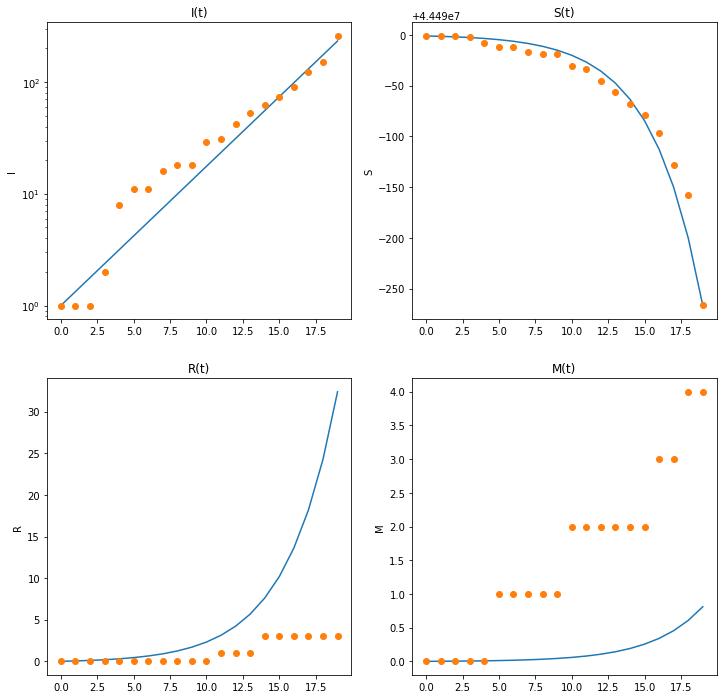

In [12]:
f=AjusteEpidemia('Argentina',44.49e6,range(20))

**Cuantos muertes hubiera habidocon elajuste precuarentena?**

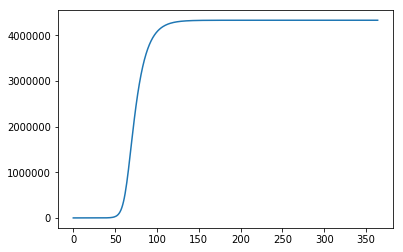

In [33]:

t=np.arange(0,365,1)
Y=f(t)
S,I,R=Y[:,0],Y[:,1],Y[:,2]
M=44.49e6-S-I-R
plt.plot(t,M)


<h2> China </h2>


alpha=0.04
R_0=8.0
d=0.001
Error Max=21.528597584057646


<function __main__.<lambda>>

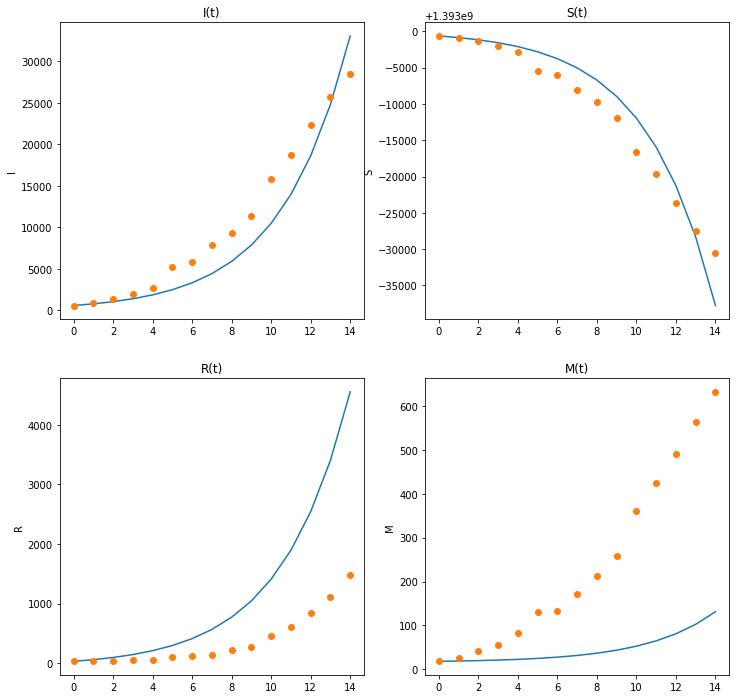

In [19]:
AjusteEpidemia('China',1393e6,range(15))

<h2> Experimento 2. Italia </h2>

alpha=0.06526315789473684
R_0=2.7368421052631575
d=0.007157894736842105
Error Max=16.834621880187434


<function __main__.<lambda>>

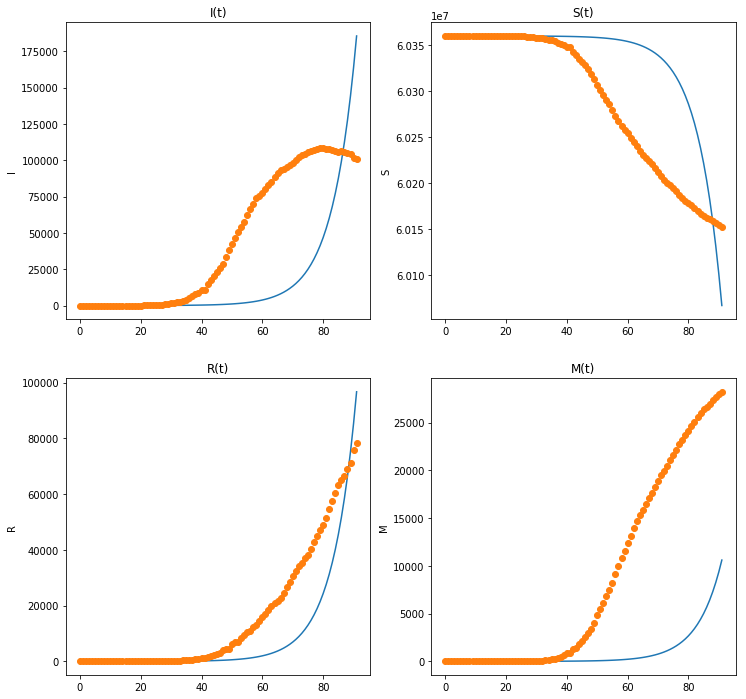

In [34]:
AjusteEpidemia('Italy', 60.36e6)

alpha=0.06526315789473684
R_0=4.0
d=0.00668421052631579
Error Max=4.900384700081518


<function __main__.<lambda>>

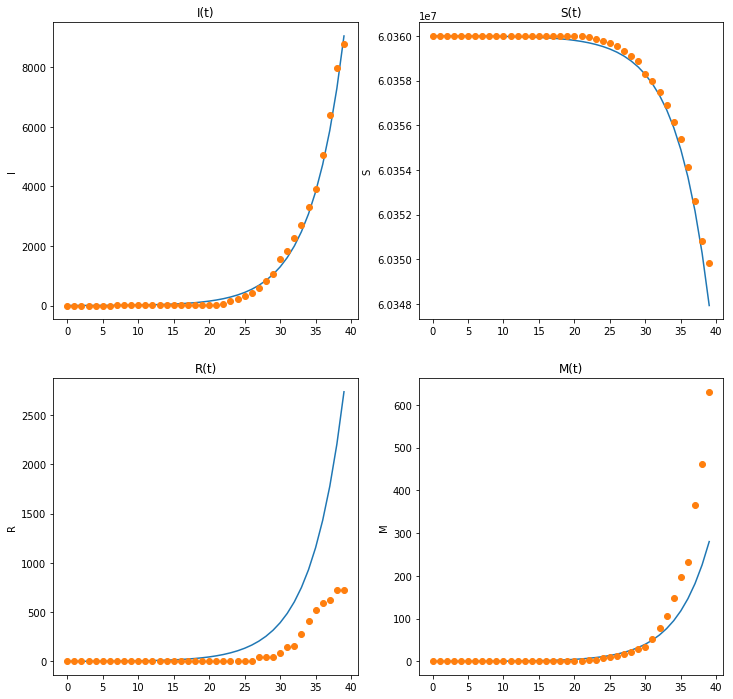

In [35]:
AjusteEpidemia('Italy', 60.36e6,range(40))

<h2> Experimento 3. España  </h2>

alpha=0.13263157894736843
R_0=1.9473684210526314
d=0.0076315789473684215
Error Max=16.659362041544465


<function __main__.<lambda>>

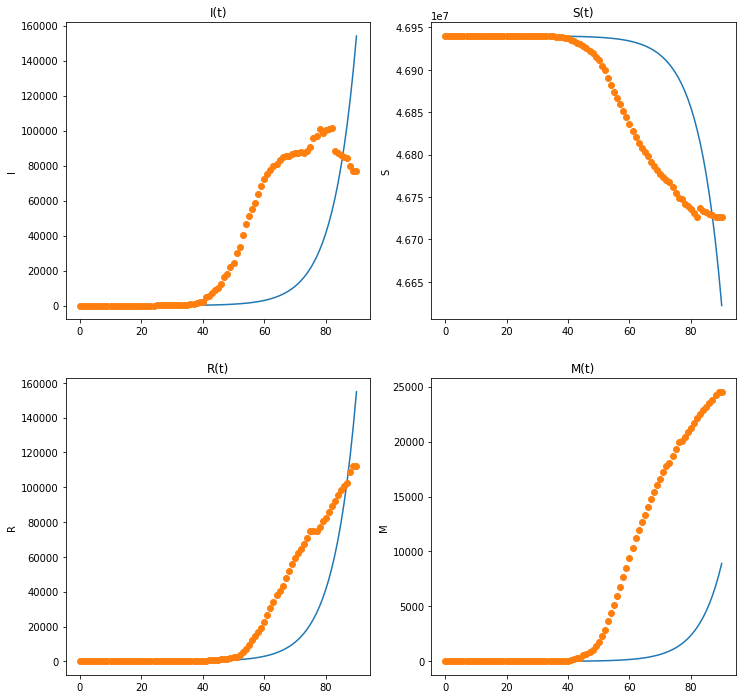

In [36]:
AjusteEpidemia('Spain', 46.94e6)

alpha=0.06526315789473684
R_0=3.8421052631578947
d=0.00668421052631579
Error Max=4.232984082796964


<function __main__.<lambda>>

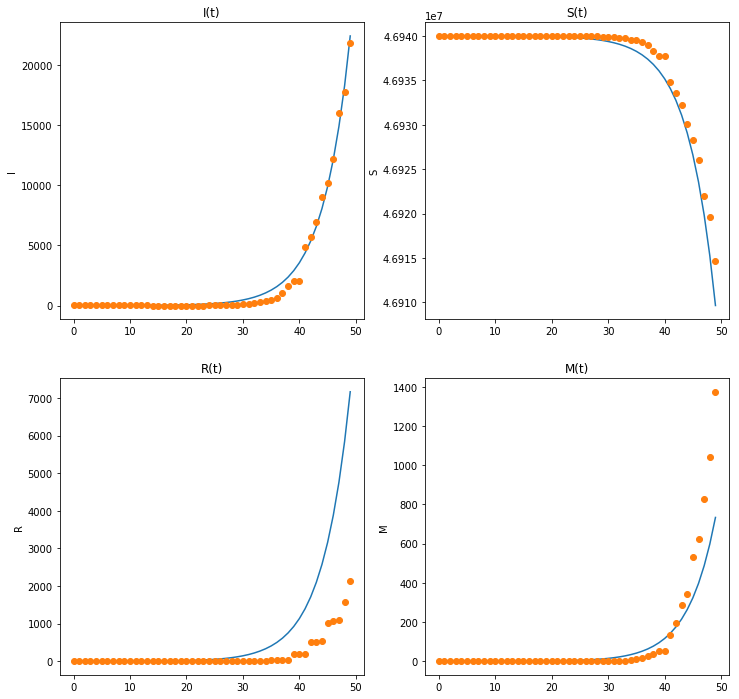

In [37]:
AjusteEpidemia('Spain', 46.94e6,range(50))

<h2> Experimento 4. Brasil  </h2>

alpha=0.09894736842105263
R_0=2.5789473684210527
d=0.009052631578947368
Error Max=8.854267098399745


<function __main__.<lambda>>

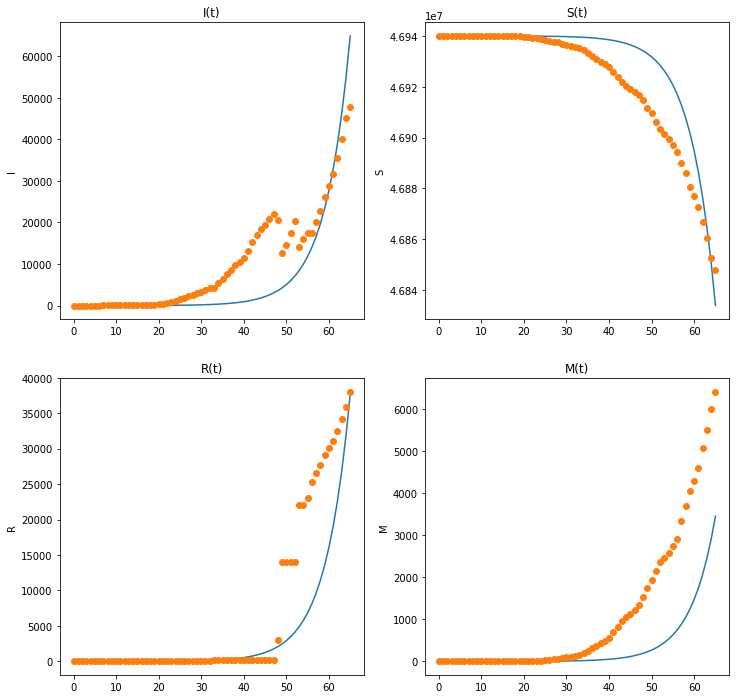

In [38]:
AjusteEpidemia('Brazil', 46.94e6)

alpha=0.04842105263157895
R_0=3.6842105263157894
d=0.008105263157894737
Error Max=20.55530960360886


<function __main__.<lambda>>

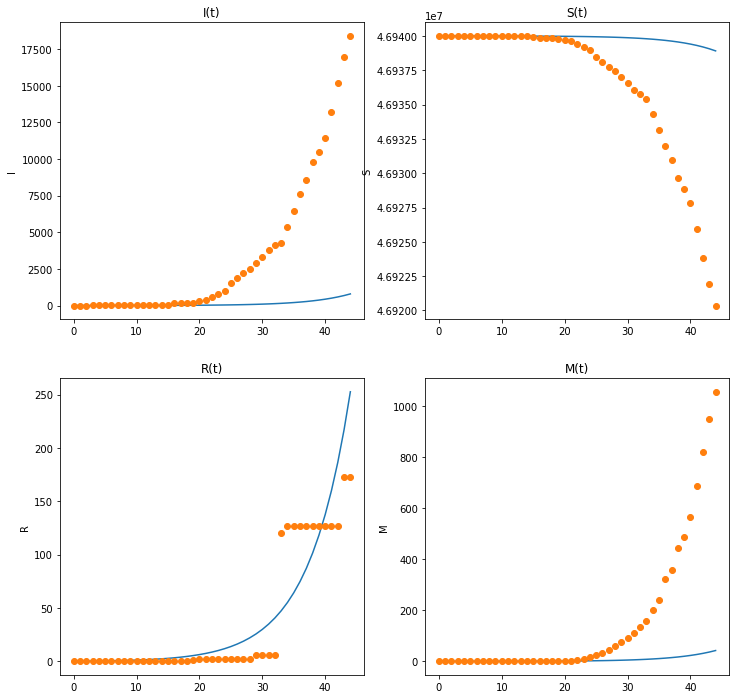

In [39]:
AjusteEpidemia('Brazil', 46.94e6,range(45))

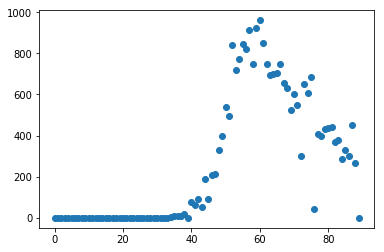

In [40]:
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('Spain', 46.94e6)
plt.plot(M_data[1:]-M_data[:-1],'o')

<h2> Experimento 5. Estados Unidos </h2>

alpha=0.04
R_0=3.8421052631578947
d=0.009526315789473685
Error Max=11.548709080883746


<function __main__.<lambda>>

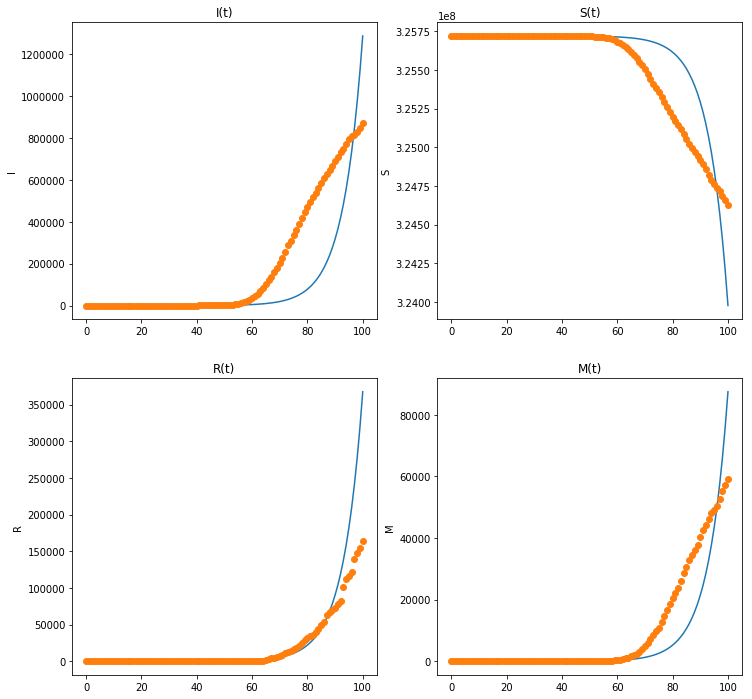

In [41]:
AjusteEpidemia('USA', 325719178)

alpha=0.04842105263157895
R_0=4.0
d=0.007157894736842105
Error Max=8.68882808336658


<function __main__.<lambda>>

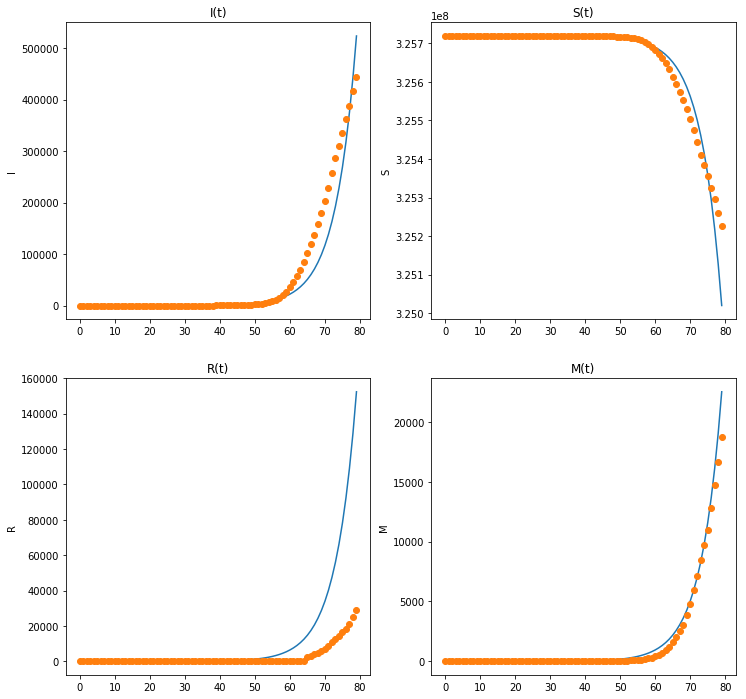

In [42]:
AjusteEpidemia('USA', 325719178,range(80))

<h1> Modelo SEIRD </h1>

<b> Bibliografía </b>

[BCF2019] "Mathematical Models in Population Biology and Epidemiology", Fred Brauer and Carlos Castillo-Chavez and Zhilan Feng, ISBN: 978-14-9399-828-9, Springer Nature,2019.

**Modelo**
 

SEIRD Susceptibles-Expuestos-Infectados-Recuperados y Defuntos por la enfermedad.  El modelo que construímos es básicamente el de sección 2.5 de [BCF2019] con la variación de incluir defunciones..


![SEIRD](SEIRD.png)



$$
\begin{aligned}
&S^{\prime}=-\beta S I-\epsilon\beta E S\\
&E^{\prime}=\beta S I+\epsilon\beta E S-k E\\
&I'=k E-(\alpha+d) I\\
&R^{\prime}=\alpha I
\end{aligned}
$$

$$\begin{aligned}
\frac{1}{\alpha}&=\text{periodo infecciosidad medio}\\
\beta&=\text{cantidad de contactos por individuo por unidad de tiempo}\\
d&=\text{tasa de mortalidad}\\
\frac{1}{k}&=\text{vida media de un expuesto}\\
\epsilon &=\text{factor de corrección de contagiosidad}\\
\mathcal{R}_0&=\beta N\left(\frac{1}{\alpha+d}+\frac{\epsilon}{k}\right)=\text{número reproducción básico}\\
            &=\text{Cantidad infecciones a lo largo de la vida de un infeccioso dentro de una población de sólo susceptibles}\\
\end{aligned}
$$


Sólo es necesario modelar las primeras dos ecuaciones

In [20]:
def SEIRD(Y,t,alpha,beta,d,k,epsilon):
    S,E,I,R=Y
    dSdt=-beta*S*I-epsilon*beta*E*S
    dEdt=beta*I*S+epsilon*beta*E*S-k*E
    dIdt=k*E-(alpha+d)*I
    dRdt=alpha*I
    return dSdt,dEdt,dIdt,dRdt
####### Resolvemos el modelos
def ModeTeorSEIRD(t,alpha,beta,d,k,epsilon,y0):
    sol = odeint(SEIRD,y0 ,t, args=(alpha,beta,d,k,epsilon))
    return sol

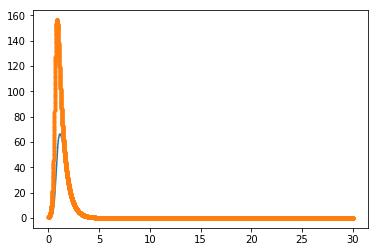

In [24]:
##########Ejemplo################
Y0=[254,1,0,0]
t = np.linspace(0,30, 10000)
argus=(2.73, 0.17,.1,1.7,0.1)

sol = odeint(SEIRD,Y0 ,t, args=argus)
S,E,I=sol[:,0],sol[:,1],sol[:,2]
plt.plot(t,I,t,E,'.')
plt.show()
#plt.yscale('log')

In [31]:
def error_Mod_SEIRD(x,*params):
    alpha,R0,d,k,epsilon=x
    t,S_data,I_data,R_data,M_data,Poblacion=params
    beta=(1/(alpha+d)+epsilon/k)**(-1)*R0/Poblacion
    E0=0
    y0=S_data[0],E0,I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeorSEIRD(t,alpha,beta,d,k,epsilon,y0)
    S=Sol[:,0]
    E=Sol[:,1]
    I=Sol[:,2]
    R=Sol[:,3]
    M=Poblacion-S-E-I-R
    ##########En el error estoy pesando más el ajuste a infectados
    return max(np.abs(I_data-I))+max(np.abs(R_data-R))+max(np.abs(M_data-M))#/(max(M_data)+1)#/(max(I_data)+1)\
#+max(np.abs(S_data-S))/(max(S_data)+1)
#+max(np.abs(R_data-R))#/(max(R_data)+1)\
#+max(np.abs(M_data-M))#/(max(M_data)+1)

def HallarParametrosSEIRD(t,S_data,I_data,R_data,M_data,Poblacion,rangos):

    ## Usaremos la búsqueda de un mínimo global mediate fuerzar bruta, 
    ## Busqueda en todo el rango

    
    #opt=scipy.optimize.brute(error_Mod_SEIRD,rangos,args=(t,S_data,I_data,R_data,M_data,Poblacion),finish=None,full_output=True)
    #para_opt,feval=opt[0:2]
    #para_opt= scipy.optimize.basinhopping(error_Mod, (1/30.0,2.0,.02))
    params=t,S_data,I_data,R_data,M_data,Poblacion
    para_opt= scipy.optimize.minimize(error_Mod_SEIRD,(1/30.0,2.0,.02,1/5.0,1.0),args=params, bounds=rangos)
    return para_opt

def AjusteEpidemiaSEIRD(Pais,Poblacion,*arg):
    S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos(Pais,Poblacion)   
    for ar in arg:
        S_data=S_data[ar]
        I_data=I_data[ar]
        M_data=M_data[ar]
        R_data=R_data[ar]
        I_data_acum=I_data_acum[ar]
    t=np.arange(0,np.shape(I_data)[0],1)
    #rangos = (slice(1/30.0,1/5.0,0.001), slice(1, 4, 0.1), slice(0.001,0.01,.001))
    rangos=(1.0/50.0,1/1.0), (.05, 6.0), (0.001,0.1), (1/100.0,1/.5),(.1,4)
    para_opt=HallarParametrosSEIRD(t,S_data,I_data,R_data,M_data,Poblacion,rangos)
    
    alpha,R0,d,k,epsilon=para_opt["x"]
    feval=para_opt["fun"]
    beta=(1/(alpha+d)+epsilon/k)**(-1)*R0/Poblacion
    ##Desconozco datos de E, lo asumo cero
    E0=0
    y0=S_data[0],E0,I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeorSEIRD(t, alpha,beta,d,k,epsilon,y0)
    S=Sol[:,0]
    E=Sol[:,1]
    I=Sol[:,2]
    R=Sol[:,3]
    M=Poblacion-S-E-I-R
    #plt.yscale('log')
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 16))
    axes[0,0].plot(t,I ,t,I_data,'o')
    axes[0,0].set_ylabel('I')
    axes[0,0].set_title('I(t)')
    axes[0,1].plot(t,S ,t,S_data,'o')
    axes[0,1].set_title('S(t)')
    axes[0,1].set_ylabel('S')
    axes[1,0].plot(t,R ,t,R_data,'o')
    axes[1,0].set_title('R(t)')
    axes[1,0].set_ylabel('R')
    axes[1,1].plot(t,M ,t,M_data,'o')
    axes[1,1].set_title('M(t)')
    axes[1,1].set_ylabel('M')
    axes[2,0].plot(t,E)
    axes[2,0].set_title('E(t)')
    axes[2,0].set_ylabel('E')
    
    print('alpha='+str(alpha)+'\n R_0='+str(R0)+'\n d='+str(d)+'\n k='+str(k)+'\n epsilon='+str(epsilon))
    print('Error Max='+str(feval))
    f=lambda t: ModeTeorSEIRD(t,alpha,beta,d,k,epsilon,y0)
    return f
    


alpha=0.1637664502905935
 R_0=2.0843214409010704
 d=0.014774323631969576
 k=0.3001282868567397
 epsilon=1.024587255190411
Error Max=12.06992061015495


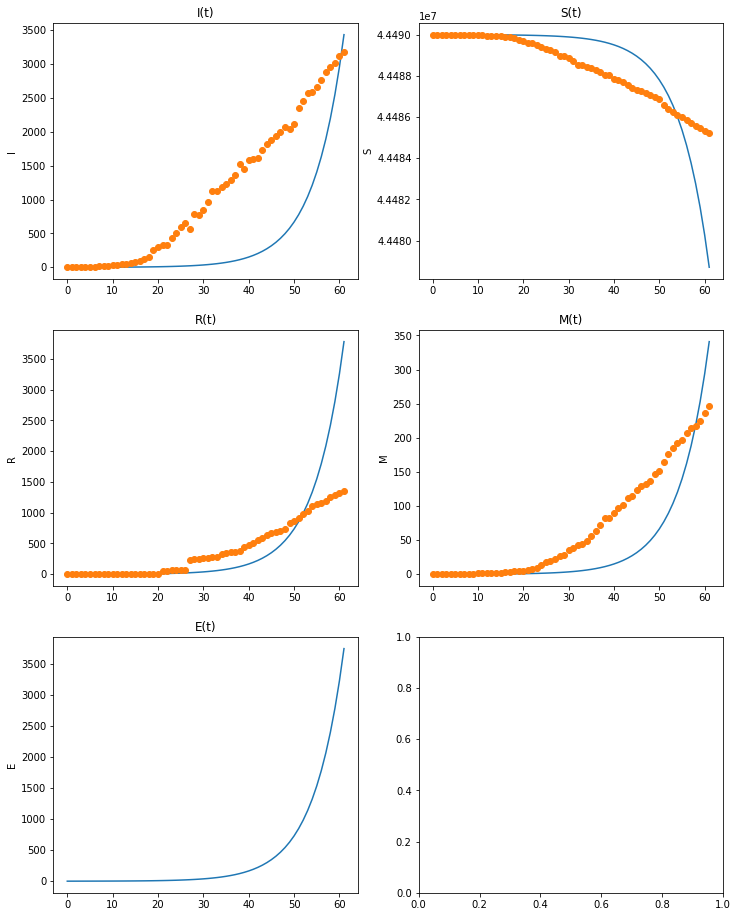

In [26]:
f=AjusteEpidemiaSEIRD('Argentina',44.49e6)

alpha=0.07279047060998181
 R_0=4.093828519205493
 d=0.009832694800295602
 k=0.6562982858380103
 epsilon=1.12844417312229
Error Max=308.12625844528833


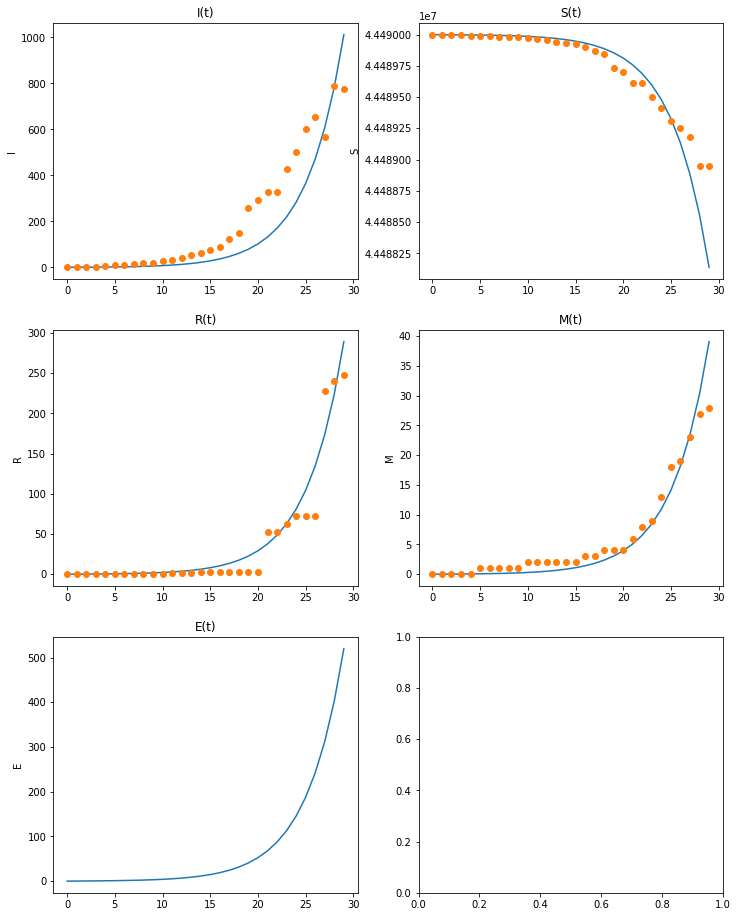

In [35]:
f=AjusteEpidemiaSEIRD('Argentina',44.49e6,range(30))

alpha=0.031635489728782315
 R_0=4.076800431634734
 d=0.026625198566355056
 k=0.4049982058492142
 epsilon=2.7544230421168128
Error Max=10201.019820862535


<function __main__.<lambda>>

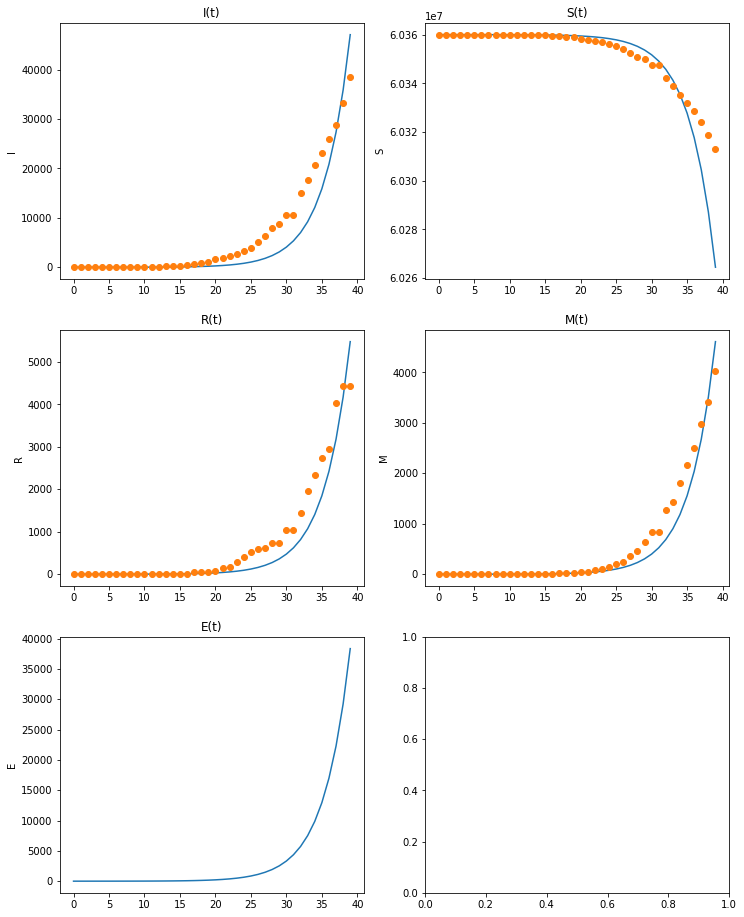

In [43]:
AjusteEpidemiaSEIRD('Italy', 60.36e6,range(10,50))

alpha=0.04230831731752449
 R_0=2.786371023342811
 d=0.0383302558184484
 k=0.2902417301381623
 epsilon=4.0
Error Max=5.153143966179583


<function __main__.<lambda>>

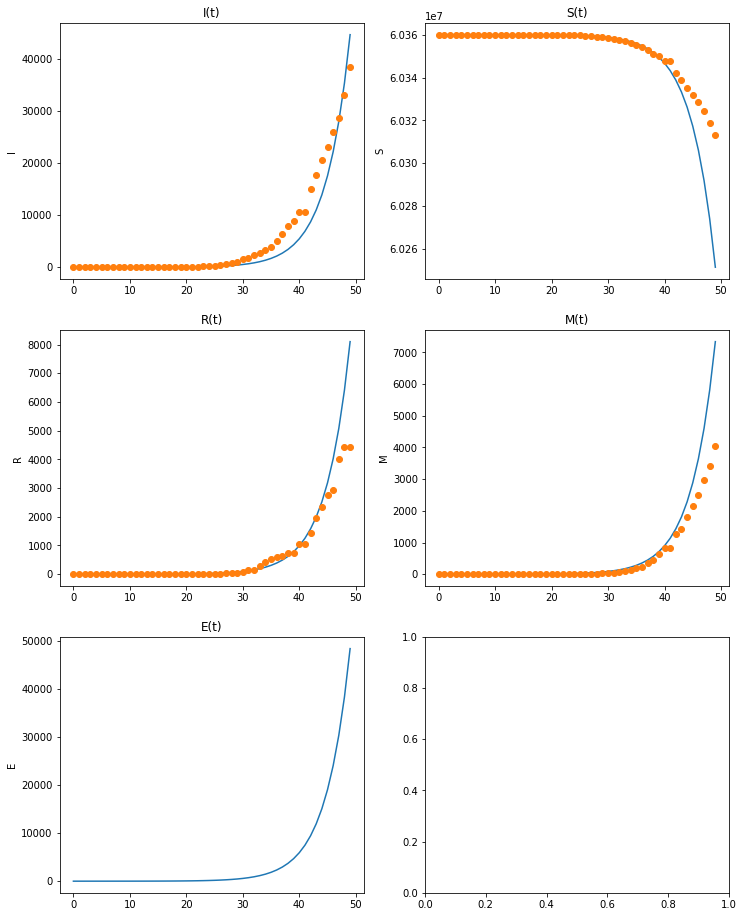

In [29]:
AjusteEpidemiaSEIRD('Italy', 60.36e6,range(50))

alpha=0.02
 R_0=1.0597613283339478
 d=0.09999999893040247
 k=0.2996057676377133
 epsilon=0.1
Error Max=21.060214440387487


<function __main__.<lambda>>

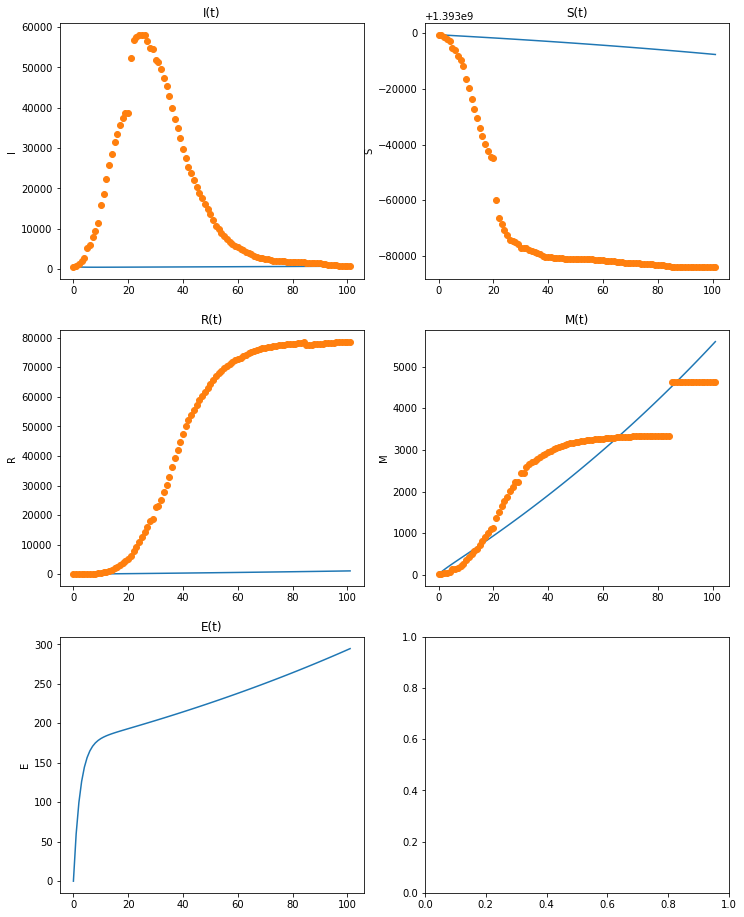

In [30]:
AjusteEpidemiaSEIRD('China',1393e6)

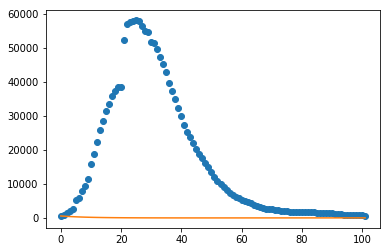

In [64]:
Poblacion=1393e6  #Segun wikipedia
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('China',Poblacion)
alpha=1/10.0
R0=2.0
epsilon=.5
k=1/1.0
d=.01
beta=(1/(alpha+d)+epsilon/k)**(-1)*R0/Poblacion
y0=S_data[0],1,I_data[0],R_data[0]
t=np.arange(0,np.shape(I_data)[0],1)
Sol=ModeTeorSEIRD(t,alpha,beta,d,k,epsilon,y0)
plt.plot(t,I_data,'o',t,Sol[:,2])